                                                  review sentiment
33553  I really liked this Summerslam due to the look...  positive
9427   Not many television shows appeal to quite as m...  positive
199    The film quickly gets to a major chase scene w...  negative
12447  Jane Austen would definitely approve of this o...  positive
39489  Expectations were somewhat high for me when I ...  negative
sentiment
positive    12517
negative    12483
Name: count, dtype: int64

=== Tópicos LDA ===
Tópico 0:  ['comedies', 'thinks', 'liners', 'quirky', 'resolution', 'satisfy', 'closed', 'jim', 'leland', 'carrey']
Tópico 1:  ['rats', 'hood', 'brooks', 'robin', 'ollie', 'muppet', 'hardy', 'garbo', 'stan', 'laurel']
Tópico 2:  ['life', 'just', 'time', 'good', 'great', 'like', 'story', 'movie', 'film', 'br']
Tópico 3:  ['net', 'players', 'stephen', 'filler', 'duke', 'enjoys', 'ease', 'cup', 'tremendous', 'soccer']
Tópico 4:  ['troma', 'lemmon', 'fay', 'matthau', 'argento', 'hartley', 'branagh', 'sha

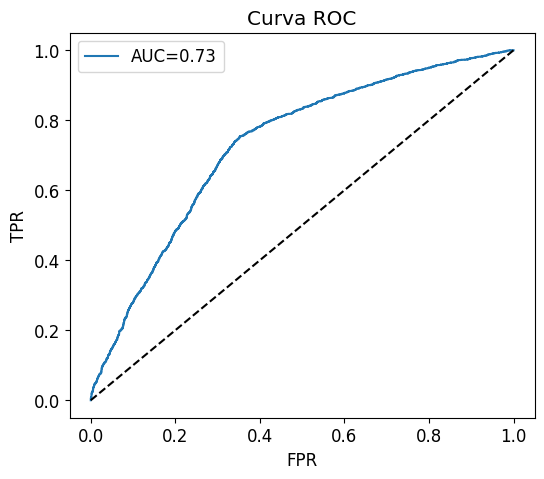

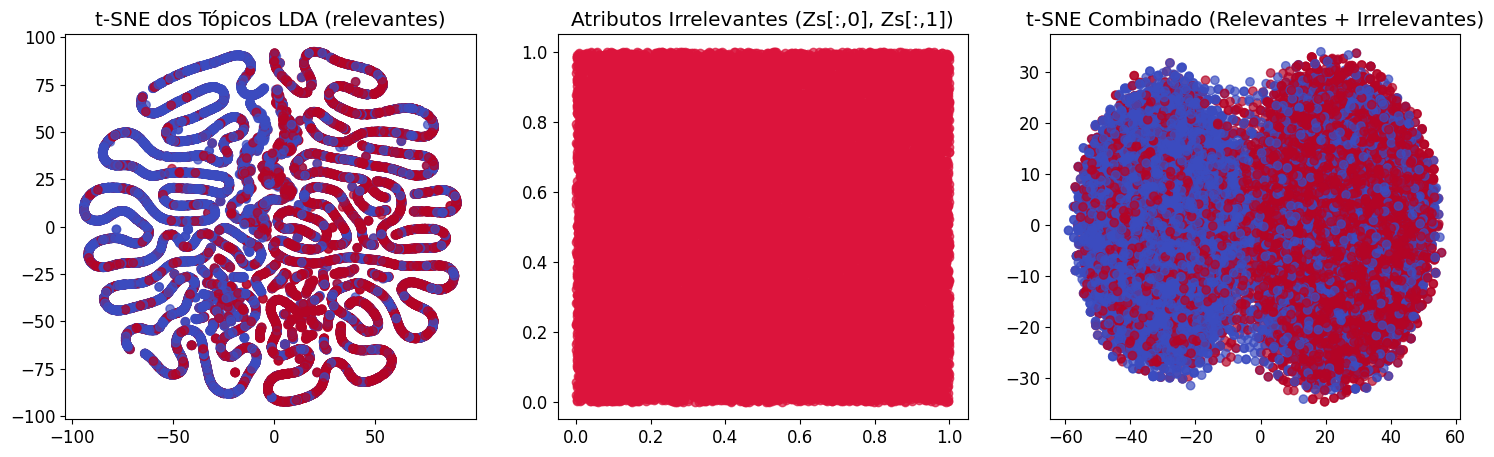


=== LIME - Explicação do Review ===
damn: -0.1499
worst: -0.0985
boring: -0.0952
cool: -0.0926
mediocre: -0.0832
immensely: 0.0789
movie: -0.0708
pulls: 0.0504
Christian: 0.0500
America: 0.0460


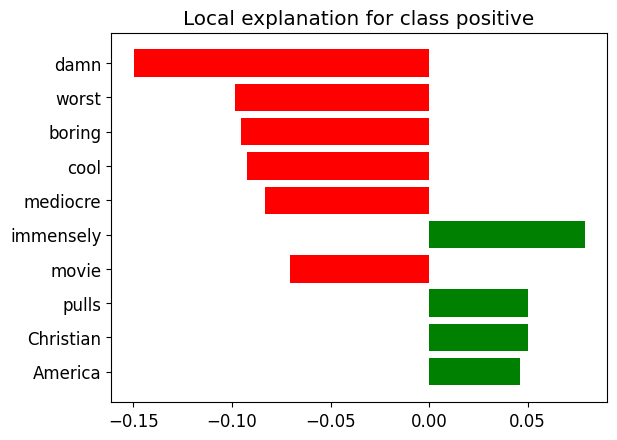


Probabilidade do modelo - Negative: 0.7316, Positive: 0.2684
Classe prevista: negative


In [69]:
# =========================
# 0. Setup e Carregamento
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import manifold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

# Carregando dataset
df = pd.read_csv(
    "dataset.csv",
    engine="python",
    quoting=1,          # trata textos entre aspas duplas
    on_bad_lines="skip" # ignora linhas quebradas
)

# Seleciona número de amostras aleatórias
df = df.sample(n=25000, random_state=42)

# Mostra primeiras linhas e distribuição de classes
print(df.head())
print(df["sentiment"].value_counts())

# Converte o target 'sentiment' em variável binária
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})

# =========================
# 1. Criação de Features - TF-IDF
# =========================

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf.fit_transform(df["review"])
y = df["label"]

# =========================
# 2. Modelagem de Tópicos - LDA
# =========================

n_topics = 25
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_topics = lda.fit_transform(X_tfidf)

terms = tfidf.get_feature_names_out()
print("\n=== Tópicos LDA ===")
for idx, topic in enumerate(lda.components_):
    print(f"Tópico {idx}: ", [terms[i] for i in topic.argsort()[-10:]])

# =========================
# 3. Classificação de Textos usando Tópicos
# =========================

X_train_topics, X_test_topics, y_train, y_test = train_test_split(
    X_topics, y, test_size=0.2, random_state=42
)

clf_topics = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid={"C":[0.01,0.1,1,10]},
    cv=5,
    scoring="f1"
)
clf_topics.fit(X_train_topics, y_train)
print("\nMelhor modelo (tópicos):", clf_topics.best_params_)

# =========================
# 4. Avaliação de Desempenho
# =========================

y_pred = clf_topics.predict(X_test_topics)
y_proba = clf_topics.predict_proba(X_test_topics)[:,1]

print("\n=== Relatório de Classificação ===")
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend()
plt.show()

# =========================
# 5. Visualização com t-SNE
# =========================

n_samples = X_topics.shape[0]
X_relevantes = X_topics
Zs = np.random.uniform(0,1,(n_samples,25))
atributos = np.concatenate((X_relevantes, Zs), axis=1)

tsne = manifold.TSNE(n_components=2, perplexity=40, learning_rate=300, random_state=42, max_iter=1000)
atributos_tsne = tsne.fit_transform(atributos)

fig, axes = plt.subplots(1,3,figsize=(18,5))

tsne_relevantes = manifold.TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, max_iter=1000).fit_transform(X_relevantes)
axes[0].scatter(tsne_relevantes[:,0], tsne_relevantes[:,1], alpha=0.7, c=df['label'].values, cmap='coolwarm')
axes[0].set_title("t-SNE dos Tópicos LDA (relevantes)")

axes[1].scatter(Zs[:,0], Zs[:,1], color='Crimson', alpha=0.7)
axes[1].set_title("Atributos Irrelevantes (Zs[:,0], Zs[:,1])")

axes[2].scatter(atributos_tsne[:,0], atributos_tsne[:,1], alpha=0.7, c=df['label'].values, cmap='coolwarm')
axes[2].set_title("t-SNE Combinado (Relevantes + Irrelevantes)")

plt.show()

# =========================
# 6. Interpretação com LIME, SHAP e Force-Plot
# =========================

# 6.1 Função de predição para LIME (TF-IDF -> LDA -> Classificador)
def predict_topics(texts):
    X_tfidf_local = tfidf.transform(texts)
    X_topics_local = lda.transform(X_tfidf_local)
    return clf_topics.predict_proba(X_topics_local)

# 6.2 LIME
explainer_lime = LimeTextExplainer(class_names=["negative","positive"])
idx = 10
texto_exemplo = df["review"].iloc[idx]

exp = explainer_lime.explain_instance(
    text_instance=texto_exemplo,
    classifier_fn=predict_topics,
    num_features=10
)

print("\n=== LIME - Explicação do Review ===")
for word, weight in exp.as_list():
    print(f"{word}: {weight:.4f}")

exp.as_pyplot_figure()
plt.show()

pred_prob = predict_topics([texto_exemplo])[0]
print(f"\nProbabilidade do modelo - Negative: {pred_prob[0]:.4f}, Positive: {pred_prob[1]:.4f}")
print(f"Classe prevista: {'positive' if pred_prob[1] > 0.5 else 'negative'}")

# 6.3 SHAP

#print(idx)
topic_labels = []
for idx, topic in enumerate(lda.components_):
    topic_labels.append(f"T{idx}")

# Substitui colunas X_train_topics e X_test_topics por DataFrames com colunas nomeadas
X_train_df = pd.DataFrame(X_train_topics, columns=topic_labels)
X_test_df = pd.DataFrame(X_test_topics, columns=topic_labels)

explainer_shap = shap.LinearExplainer(clf_topics.best_estimator_, X_train_df, feature_perturbation="interventional")
shap_values = explainer_shap.shap_values(X_test_df[:5])

# Force plot para a primeira amostra
shap.initjs()
shap.force_plot(explainer_shap.expected_value, shap_values[0], X_test_df.iloc[0])

# =========================
# 7. Análise dos resultados
# =========================
'''
1. Dataset balanceado: 12.517 positivos vs 12.483 negativos, evita viés significativo entre classes.

2. LDA extraiu 25 tópicos coerentes com termos reconhecíveis, permitindo identificar temas e padrões nos reviews.
   - Alguns tópicos são específicos de personagens/filmes (ex.: Tópico 0: 'carrey', 'jim'; Tópico 9: 'bond', 'spock')
   - Outros são mais gerais (ex.: Tópico 2: 'life', 'story', 'movie'), refletindo padrões semânticos.

3. Classificador baseado em tópicos:
   - Melhor hiperparâmetro C = 10
   - Desempenho geral: Acurácia ≈ 0.70, F1 ≈ 0.70, ROC AUC ≈ 0.73
   - Recall negativo = 0.65, Recall positivo = 0.75 → acerta mais reviews positivos

4. Visualização t-SNE:
   - Clusters parcialmente separados entre reviews positivos e negativos
   - Inclusão de atributos irrelevantes gera maior dispersão e sobreposição

5. LIME explica individualmente palavras que mais influenciam a previsão:
   - Negativo: 'damn', 'worst', 'boring', 'mediocre'
   - Positivo: 'immensely', 'beautiful', 'pulls'
   - Indica que o modelo captura indicadores semânticos coerentes

6. SHAP reforça quais tópicos contribuem para a previsão individual

7. Conclusões:
   - O modelo captura informações relevantes dos tópicos extraídos
   - Separação moderada entre classes, desempenho decente, mas há espaço para melhoria
   - Técnicas de interpretabilidade (LIME, SHAP) permitem entender quais termos/tópicos impactam as decisões
   - Possível melhoria: combinar LDA com TF-IDF direto ou explorar modelos mais complexos
'''